In [1]:
%pip install odc-stac -q
%pip install odc-geo -q
%pip install odc-algo -q
%pip install mapclassify -q
%pip install folium -q


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import os
from io import StringIO
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

from IPython.display import display
from pystac_client import Client

import odc.stac
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry, CRS
import odc.geo.xr
from odc.stac import configure_rio, load
import xarray as xr
import rioxarray

import pandas as pd
import dask.distributed


import mapclassify
import folium


In [3]:
odc.stac.configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
# Function to list all .tif files in the specified directory
def list_tif_files(path):
    return [f for f in os.listdir(path) if f.endswith('.tif')]

# Function to load and display the selected .tif file
def load_and_display_tif(output_path, filename):
    filepath = os.path.join(output_path, filename)
    img = gv.util.from_xarray(rioxarray.open_rasterio(filepath).rio.reproject('EPSG:3857'))
    
    # Define map tiles and create the map image
    map_tiles = gv.tile_sources.EsriImagery().opts(width=1000, height=600)
    map_img = gv.Image(img, kdims=['x', 'y']).opts(cmap='viridis', title=filename)
    map_combo = map_tiles * map_img
    
    return map_combo

In [5]:
# defining input geometry

# option one: mimic payload recieved from FE
# geojson = {
#     'body': {
#         "type": "FeatureCollection",
#         "name": "dissolved-boundaries",
#         "crs": {
#             "type": "name",
#             "properties": {
#                 "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
#             }
#         },
#         "features": [
#             {
#                 "type": "Feature",
#                 "properties": {
#                     "fid": 1
#                 },
#                 "geometry": {
#                     "type": "Polygon",
#                     "coordinates": [
#                         [
#                             [116.26012130269045, -29.225295369642396],
#                             [116.261724812149055, -29.241374854584375],
#                             [116.283751968396274, -29.256813692452539],
#                             [116.284342735038919, -29.268250184258388],
#                             [116.292247755352392, -29.265992437426529],
#                             [116.292360282331941, -29.293057573630019],
#                             [116.314865678242256, -29.293523728033122],
#                             [116.326259034921833, -29.293033039128805],
#                             [116.326315298411629, -29.305397680579894],
#                             [116.355065941687045, -29.307016748931797],
#                             [116.355065941687045, -29.306575187382712],
#                             [116.383366477044206, -29.307384715430175],
#                             [116.384322956370426, -29.290407813444993],
#                             [116.387586238777402, -29.282629879611861],
#                             [116.386517232471661, -29.259807919053017],
#                             [116.359201308185533, -29.259488866292969],
#                             [116.359229439930417, -29.259243440415627],
#                             [116.35242155766754, -29.259292525638209],
#                             [116.352140240218716, -29.220237788279107],
#                             [116.302234524787593, -29.223503148505326],
#                             [116.281388901825679, -29.2239696200396],
#                             [116.26012130269045, -29.225295369642396]
#                         ]
#                     ]
#                 }
#             }
#         ]
#     }
# }

# req = geojson
# geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# # Convert the GeoJSON string to a GeoDataFrame
# gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))
# geom = gdf.geometry #for data-harvester clip function
# geom_crs = geom.to_crs("EPSG:4326")
# bbox = list(geom_crs.total_bounds)

# option 2 load geom from file

# testing with large onebasin area:

geom_filepath = "/workspace/notebooks/sandbox/data/input-data/onebasin/Surface Water Water Resource Plan Areas/Surface Water Water Resource Plan Areas.shp"
gdf = gpd.read_file(geom_filepath)

geom_gdf = gdf.loc[gdf['SWWRPACODE'] == 'SW1']
geom = geom_gdf.geometry
geom_crs = geom.to_crs("EPSG:4326") #needs to be 4326 to work with pystac_client for searching
bbox = list(geom_crs.total_bounds)


print(gdf.crs)
gdf.head()

EPSG:4283


,SWWRPANAME,SWWRPACODE,STATE,geometry
0,Barwon-Darling Watercourse,SW12,NSW,"MULTIPOLYGON (((148.80173 -29.18485, 148.80119..."
1,Condamine-Balonne,SW19,QLD,"POLYGON ((151.96698 -28.51227, 151.96697 -28.5..."
2,Eastern Mount Lofty Ranges,SW7,SA,"POLYGON ((139.17398 -34.50310, 139.18024 -34.5..."
3,Gwydir,SW15,NSW,"MULTIPOLYGON (((151.66687 -29.98005, 151.66687..."
4,Intersecting Streams,SW13,NSW,"MULTIPOLYGON (((143.38390 -31.55762, 143.38422..."


In [6]:
#gdf.explore(column="SWWRPACODE")
#geom.explore()

In [7]:
#papermill_description=parameters
local=True
map_results = False

notebook_key = "localjupyter"

propertyName = "test"
output_type = "overlay"
colormap = "gist_earth"

# new parameters to enable multiple SLGA attributes to be fetched
dem_layer = "DEM"

In [8]:
output_tiff_directory = f"/tmp/{notebook_key}"
if local:
    output_tiff_directory = "/workspace/notebooks/sandbox/data/slga_testing"

# Ensure the storage directory exists
os.makedirs(output_tiff_directory, exist_ok=True)

In [9]:
url = "https://earth-search.aws.element84.com/v1/"
collection = ["cop-dem-glo-30"]

start_date = "2024-04-01"
end_date = "2024-05-01"

bands = ("red", "green", "blue")

resolution = 90 #this is not the DEM native resolution, only for speeding up testing
crs = 3857

In [10]:
catalog = Client.open(url)

In [11]:
query = catalog.search(
    collections=collection,
    bbox=bbox
)

In [12]:
items = list(query.items())
print(f"Found {len(items):d} datasets")

#convert the fetched stac items to a geojson featurecollection
stac_json = query.item_collection_as_dict()


Found 2 datasets


In [13]:

#lazily combine
xx = load(
    items,
    crs=f"epsg:{crs}",
    resolution = resolution,
    bbox = bbox,
    chunksize = (2000,2000)
).squeeze()

# data is not loaded yet
xx

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 1211, x: 788)
Coordinates:
  * y            (y) float64 10kB -4.181e+06 -4.181e+06 ... -4.29e+06 -4.29e+06
  * x            (x) float64 6kB 1.656e+07 1.656e+07 ... 1.663e+07 1.663e+07
    spatial_ref  int32 4B 3857
    time         datetime64[ns] 8B 2021-04-22
Data variables:
    data         (y, x) float32 4MB 845.5 840.1 831.4 ... 1.145e+03 1.146e+03

In [14]:
xx = xx.load()

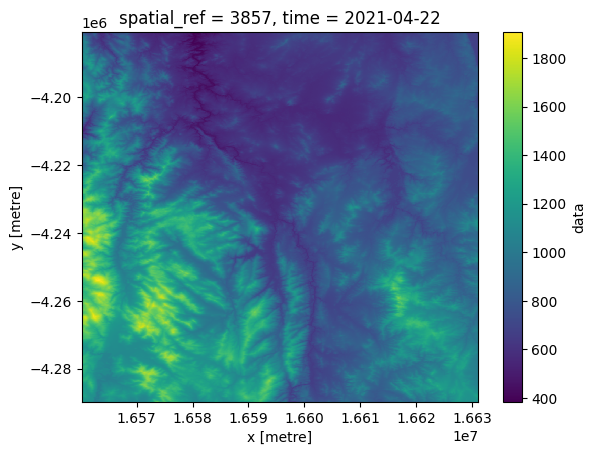

In [15]:
data = xx.data
data.plot()

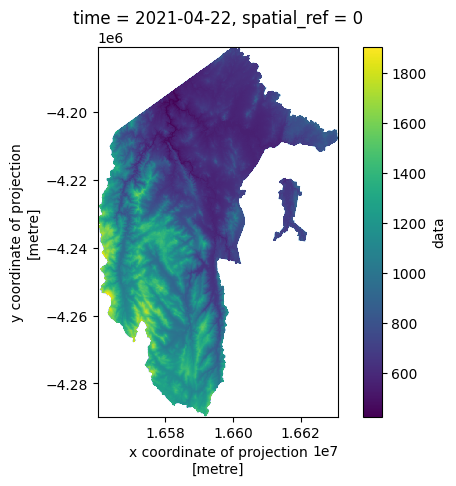

In [16]:
# test saving the xarray dataset as a geotiff

# convert original polygon to same CRS as raster

clip_geom = geom_gdf.to_crs(f"EPSG:{crs}")

clip_geom.plot()

mask_raster = data.rio.clip(clip_geom.geometry.values, clip_geom.crs, drop=False)

mask_raster.plot()

In [17]:

test_save = mask_raster.rio.to_raster(f"{output_tiff_directory}/test_save.tif", driver="COG")

In [18]:
# dem_stac = (stac.image_collection(collection))\
#     .from_STAC(url)\
#     .filter_bounds(bbox)\
#     .filter_date(start_date, end_date)\
#     .get_items(bbox=bbox, 
#                bands=bands,
#                crs=crs, 
#                resolution = resolution,
#                resampling="bilinear")